In [527]:
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from pickle import dump
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV



In [528]:
import os
print(os.getcwd())

/Users/mattomalley/mds8-final-project-bmh-1/EDA


In [529]:
# Loading data from SQLite to pandas

path_to_db = '/Users/mattomalley/mds8-final-project-bmh-1/data/raw/rentcast_FL.db'
conn = sqlite3.connect(path_to_db)
query = """SELECT * FROM properties"""
data = pd.read_sql(query, conn)
conn.close()
data.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,foundationType,garage,garageSpaces,garageType,pool,roomCount,unitCount,viewType
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.551645,-80.042184,Single Family,8.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
1,"5018-Coquina-Key-Dr-SE,-Saint-Petersburg,-FL-3...","5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,FL,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,...,0,2.0,None,0,NaN,None,True,NaN,1.0,Water
2,"1070-Rhonda-Rd,-Jacksonville,-FL-32254","1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,FL,32254,Duval,30.339189,-81.717711,Single Family,3.0,...,0,1.0,None,1,4.0,Garage,False,NaN,1.0,None
3,"2200-S-Ocean-Dr,-Apt-N108,-Hollywood,-FL-33019","2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.999305,-80.118487,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
4,"6065-Parkwalk-Dr,-Boynton-Beach,-FL-33472","6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,FL,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None


In [530]:
data = data[data['yearBuilt'] <= 2025]

data['years_old'] = 2025 - data['yearBuilt']

In [531]:
# Changing the multiple ways to designate pool into 1/0

bool_mapper = {
    '1':1,
    '0':0,
    'True':1,
    'False':0,
    'Inground':1,
    'Type Unknown': 1,
    'Pool/spa':1
}

data['pool'] = data['pool'].map(bool_mapper).fillna(0).astype(int)

In [532]:
# Creating column with average interest rates from FRED

data.lastSaleDate = pd.to_datetime(data.lastSaleDate)

data['year_month'] = data['lastSaleDate'].dt.to_period('M')

t_rate = {
    '2024-03':0.0421,
    '2024-04':0.0454,
    '2024-05':0.0448,
    '2024-06':0.0431,
    '2024-07':0.0425,
    '2024-08':0.0387,
    '2024-09':0.0372,
    '2024-10':0.041,
    '2024-11':0.0436,
    '2024-12':0.0439,
    '2025-01':0.0463,
    '2025-02':0.0445,
    '2025-03':0.0668
}

data['year_month'] = data['year_month'].dt.strftime('%Y-%m')

data['t_rate'] = data['year_month'].map(t_rate)


/var/folders/9k/_6hsswr52z55gh1n7b83gb2m0000gn/T/ipykernel_29708/976391788.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['lastSaleDate'].dt.to_period('M')


In [533]:
data.columns.tolist()

['id',
 'formattedAddress',
 'city',
 'state',
 'zipCode',
 'county',
 'latitude',
 'longitude',
 'propertyType',
 'bedrooms',
 'bathrooms',
 'squareFootage',
 'lotSize',
 'yearBuilt',
 'subdivision',
 'zoning',
 'lastSaleDate',
 'lastSalePrice',
 'hoa',
 'architectureType',
 'cooling',
 'coolingType',
 'heating',
 'heatingType',
 'exteriorType',
 'fireplace',
 'floorCount',
 'foundationType',
 'garage',
 'garageSpaces',
 'garageType',
 'pool',
 'roomCount',
 'unitCount',
 'viewType',
 'years_old',
 'year_month',
 't_rate']

In [534]:
cols = [
    # 'id',
    'formattedAddress',
    'city',
    # 'state',
    'zipCode',
    'county',
    'latitude',
    'longitude',
    'propertyType',
    'bedrooms',
    'bathrooms',
    'squareFootage',
    'lotSize',
    'yearBuilt',
    # 'subdivision',
    # 'zoning',
    # 'lastSaleDate',
    'lastSalePrice',
    # 'hoa',
    # 'architectureType',
    'cooling',
    # 'coolingType',
    'heating',
    # 'heatingType',
    # 'exteriorType',
    'fireplace',
    'floorCount',
    # 'foundationType',
    'garage',
    'garageSpaces',
    # 'garageType',
    'pool',
    # 'roomCount',
    # 'unitCount',
    # 'viewType',
    'years_old',
    't_rate',
    ]

In [535]:
data = data[cols]
data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
1,"5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,1.5,1022.0,...,469000.0,0,0,0,2.0,0,NaN,1,46.0,0.0421
2,"1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,32254,Duval,30.339189,-81.717711,Single Family,3.0,1.0,1192.0,...,170000.0,1,1,0,1.0,1,4.0,0,74.0,0.0421
3,"2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,33019,Broward,25.999305,-80.118487,Condo,2.0,2.0,865.0,...,300000.0,0,0,0,NaN,0,NaN,0,60.0,0.0421
4,"6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,2.0,1335.0,...,250000.0,0,0,0,NaN,0,NaN,0,39.0,0.0421
5,"8734 Carmel Mountain Way, Boynton Beach, FL 33473",Boynton Beach,33473,Palm Beach,26.493040,-80.183199,Single Family,3.0,2.5,2338.0,...,765000.0,1,1,0,1.0,1,NaN,1,11.0,0.0421


In [536]:
data['cooling'].isna().any()

np.False_

In [537]:
data['propertyType'].unique()

array(['Townhouse', 'Single Family', 'Condo', 'Multi-Family', 'Land',
       'Manufactured', 'Apartment', None], dtype=object)

In [538]:
prop_types = [
    'Single Family', 
    'Townhouse', 
    'Condo', 
    # 'Multi-Family', 
    # 'Land',
    'Manufactured', 
    # 'Apartment',
]

In [539]:
data = data[data['propertyType'].isin(prop_types)]

In [540]:
data.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
1,"5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,1.5,1022.0,...,469000.0,0,0,0,2.0,0,NaN,1,46.0,0.0421
2,"1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,32254,Duval,30.339189,-81.717711,Single Family,3.0,1.0,1192.0,...,170000.0,1,1,0,1.0,1,4.0,0,74.0,0.0421
3,"2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,33019,Broward,25.999305,-80.118487,Condo,2.0,2.0,865.0,...,300000.0,0,0,0,NaN,0,NaN,0,60.0,0.0421
4,"6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,2.0,1335.0,...,250000.0,0,0,0,NaN,0,NaN,0,39.0,0.0421
5,"8734 Carmel Mountain Way, Boynton Beach, FL 33473",Boynton Beach,33473,Palm Beach,26.493040,-80.183199,Single Family,3.0,2.5,2338.0,...,765000.0,1,1,0,1.0,1,NaN,1,11.0,0.0421


In [541]:
data.shape

(119951, 22)

In [542]:
# Filling nulls in lotSize for Condos with 0

data.loc[(data['propertyType'] == 'Condo') & (data['lotSize'].isnull()), 'lotSize'] = 0

In [543]:
# Filling nulls in floor count with 1

data['floorCount'] = data['floorCount'].fillna(1)

In [544]:
# Filling nulls in garageSpaces with 1

data['garageSpaces'] = data['garageSpaces'].fillna(1)

In [545]:
data = data.dropna()
data.shape

(114713, 22)

In [546]:
data['lastSalePrice'].describe()

count    1.147130e+05
mean     5.478487e+05
std      1.851406e+06
min      3.100000e+02
25%      2.550000e+05
50%      3.699000e+05
75%      5.450000e+05
max      3.450000e+08
Name: lastSalePrice, dtype: float64

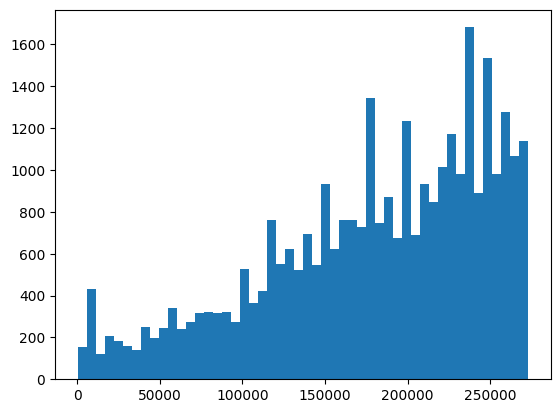

In [547]:
low_price = data[data['lastSalePrice'] < 273000]

plt.hist(low_price['lastSalePrice'], bins=50)
plt.show()

In [548]:
very_low = data[data['lastSalePrice'] < 50000]
very_low.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1856 entries, 17 to 145570
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   formattedAddress  1856 non-null   object 
 1   city              1856 non-null   object 
 2   zipCode           1856 non-null   int64  
 3   county            1856 non-null   object 
 4   latitude          1856 non-null   float64
 5   longitude         1856 non-null   float64
 6   propertyType      1856 non-null   object 
 7   bedrooms          1856 non-null   float64
 8   bathrooms         1856 non-null   float64
 9   squareFootage     1856 non-null   float64
 10  lotSize           1856 non-null   float64
 11  yearBuilt         1856 non-null   float64
 12  lastSalePrice     1856 non-null   float64
 13  cooling           1856 non-null   int64  
 14  heating           1856 non-null   int64  
 15  fireplace         1856 non-null   int64  
 16  floorCount        1856 non-null   float64
 1

In [549]:
very_low.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
count,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1.856000e+03,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000
mean,33694.045259,28.387355,-82.098982,2.923491,1.919181,1484.111530,2.004213e+04,1998.526940,24004.441810,0.501078,0.531789,0.080819,1.030711,0.402478,1.077047,0.046875,26.473060,0.043364
std,847.335199,1.300961,1.253845,0.801997,0.555481,539.084268,1.229325e+05,27.690459,14349.527576,0.500134,0.499123,0.272630,0.178719,0.490530,0.316639,0.211428,27.690459,0.002142
min,32008.000000,25.092931,-87.433430,1.000000,0.500000,200.000000,0.000000e+00,1891.000000,310.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.037200
25%,32909.000000,26.994397,-82.270068,2.000000,2.000000,1136.000000,7.405000e+03,1978.000000,10000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.042100
50%,33955.500000,28.865827,-82.009606,3.000000,2.000000,1456.000000,1.001900e+04,2004.000000,22600.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,21.000000,0.043100
75%,34470.000000,29.145343,-81.630390,3.000000,2.000000,1810.000000,1.306800e+04,2024.000000,38000.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,47.000000,0.045400
max,34997.000000,30.971297,-80.053292,6.000000,6.000000,6009.000000,3.746160e+06,2025.000000,49900.000000,1.000000,1.000000,1.000000,3.000000,1.000000,6.000000,1.000000,134.000000,0.046300


In [550]:
very_low[very_low['bedrooms'] == 6]

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,garageSpaces,pool,years_old,t_rate
1463,"1115 Joseph St, Jacksonville, FL 32206",Jacksonville,32206,Duval,30.346933,-81.640630,Single Family,6.0,2.0,1474.0,...,48900.0,1,1,0,2.0,0,1.0,0,111.0,0.0421
91479,"1045 E 24th St, Jacksonville, FL 32206",Jacksonville,32206,Duval,30.359815,-81.641962,Single Family,6.0,3.5,1723.0,...,45000.0,1,1,1,1.0,0,1.0,0,97.0,0.0431
124552,"2223 Carver Ave, Fort Myers, FL 33916",Fort Myers,33916,Lee,26.638425,-81.846618,Single Family,6.0,5.0,1832.0,...,47000.0,0,0,0,1.0,0,1.0,0,1.0,0.0387
124559,"2219 Carver Ave, Fort Myers, FL 33916",Fort Myers,33916,Lee,26.638720,-81.846619,Single Family,6.0,5.0,2000.0,...,47000.0,0,0,0,1.0,0,1.0,0,1.0,0.0387


These are either inaccurate or very old without renovations. May need to filter for both year built and price range.

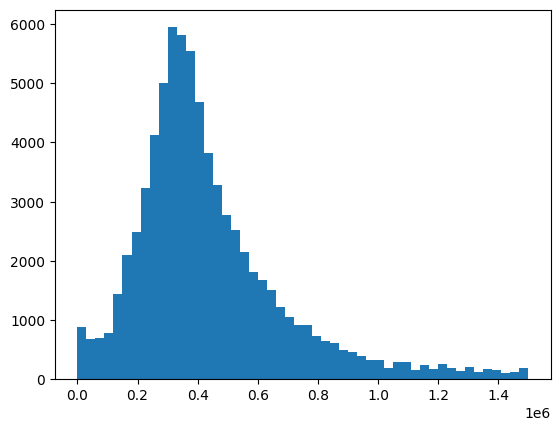

In [551]:
newer = data[data['yearBuilt'] >= 1980]

plt.hist(newer['lastSalePrice'], bins=50, range=(0, 1_500_000))
plt.show()

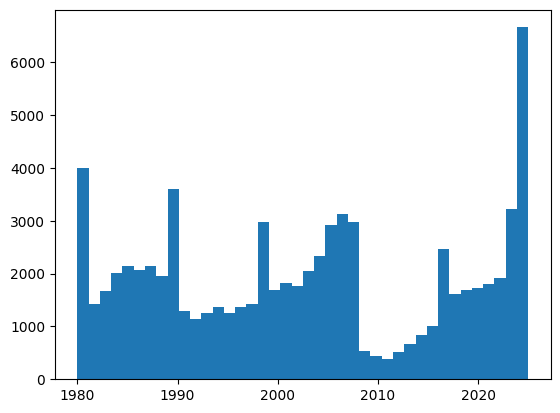

In [552]:
plt.hist(newer['yearBuilt'], bins=40)
plt.show()

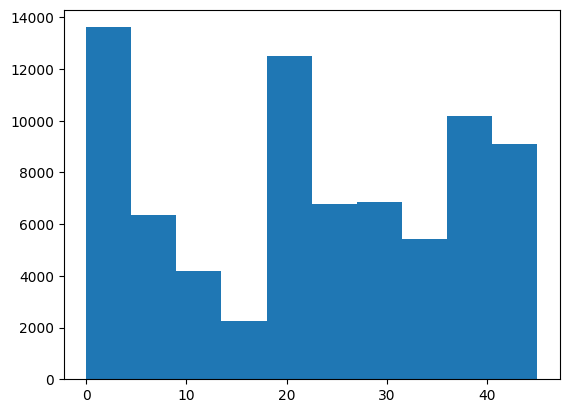

In [553]:
plt.hist(newer['years_old'])
plt.show()

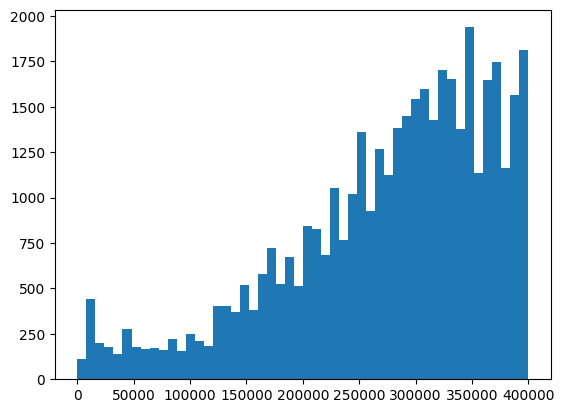

In [554]:
# Zooming in on that lower dip

plt.hist(newer['lastSalePrice'], bins=50, range=(0, 400000))
plt.show()

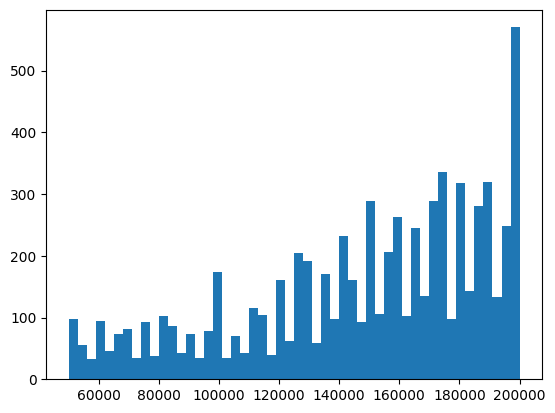

In [555]:
plt.hist(newer['lastSalePrice'], bins=50, range=(50000, 200000))
plt.show()

In [556]:
# filtering by price

filtered = newer[(newer['lastSalePrice'] > 100_000) & ((newer['lastSalePrice'] < 1_000_000))]

In [557]:
filtered.shape

(68224, 22)

In [558]:
filtered['county'].value_counts().head(15)

county
Palm Beach      4739
Lee             4693
Hillsborough    4460
Orange          3682
Polk            3562
Broward         3462
Miami-Dade      3454
Duval           3049
Pasco           2875
Osceola         2271
Marion          2217
Volusia         2183
Brevard         2043
Manatee         2041
Sarasota        1985
Name: count, dtype: int64

In [559]:
county_counts = filtered['county'].value_counts()
big_counties= county_counts[county_counts >= 2216].index

filtered = filtered[filtered['county'].isin(big_counties)]

filtered.shape

(38464, 22)

In [560]:
filtered = filtered.copy()
filtered['zipCode'] = filtered['zipCode'].astype(str)

In [561]:
num_var = [
    'latitude',
    'longitude',
    'bedrooms',
    'bathrooms',
    'squareFootage',
    'lotSize',
    # 'yearBuilt',
    # 'subdivision',
    # 'zoning',
    # 'lastSaleDate',
    'floorCount',
    'lastSalePrice',
    'years_old',
    'pool',
    'cooling',
    'heating',
    'fireplace',
    'garage',
    'garageSpaces',
    't_rate',
]

cat_var = [
    'city',
    'zipCode',
    'county',
    'propertyType',
]

In [562]:
# Getting dummies for cat_var

cat_data = pd.get_dummies(filtered[cat_var])

# Recreating the dataframe with the numerical and dummy columns 

filtered = pd.concat([filtered[num_var], cat_data], axis=1)

# # Getting columns for dummy variables

# cat_var = cat_data.columns.astype(str).tolist()

In [563]:
filtered.head()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,floorCount,lastSalePrice,years_old,pool,...,county_Miami-Dade,county_Orange,county_Osceola,county_Palm Beach,county_Pasco,county_Polk,propertyType_Condo,propertyType_Manufactured,propertyType_Single Family,propertyType_Townhouse
4,26.556118,-80.137678,2.0,2.0,1335.0,43560.0,1.0,250000.0,39.0,0,...,False,False,False,True,False,False,True,False,False,False
5,26.493040,-80.183199,3.0,2.5,2338.0,10171.0,1.0,765000.0,11.0,1,...,False,False,False,True,False,False,False,False,True,False
6,28.238025,-82.444252,3.0,2.0,1579.0,6897.0,1.0,355000.0,15.0,0,...,False,False,False,False,True,False,False,False,True,False
9,26.566303,-81.882644,2.0,2.0,630.0,958.0,2.0,220000.0,44.0,0,...,False,False,False,False,False,False,False,False,True,False
15,27.899249,-82.352937,3.0,2.0,1880.0,3222.0,2.0,340000.0,7.0,0,...,False,False,False,False,False,False,False,False,True,False


In [564]:
# Features and target, splitting data

y = filtered['lastSalePrice']
X = filtered.drop(['lastSalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [565]:
X_train.shape

(30771, 650)

In [566]:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 200,
 'reg_alpha': 0,
 'reg_lambda': 1.5,
 'subsample': 0.8}

In [567]:
# XGBoost Regressor

xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 83739.39939034206
Coefficient of determination: 0.7940528132178881


In [568]:
# colsample_bytree=0.8, 
# learning_rate=0.1, 
# max_depth=8, 
# n_estimators=200, 
# reg_alpha=0, 
# reg_lambda=1.5, 
# subsample=0.8

In [569]:
param_grid = {
    'n_estimators': [100, 200],            # Control training time + accuracy
    'max_depth': [4, 6, 8],                # Controls model complexity
    'learning_rate': [0.05, 0.1],          # Lower = more accurate, but slower
    'subsample': [0.8, 1.0],               # Prevent overfitting
    'colsample_bytree': [0.8, 1.0],        # Same
    'reg_alpha': [0, 0.1],                 # L1 regularization
    'reg_lambda': [1, 1.5]                 # L2 regularization
}


In [570]:
xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    random_state=42,
    colsample_bytree=0.8, 
    learning_rate=0.1, 
    max_depth=8, 
    n_estimators=200, 
    reg_alpha=0, 
    reg_lambda=1.5, 
    subsample=0.8)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

# # Grid search setup
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',
#     cv=3,             # 3-fold = balanced speed/accuracy
#     verbose=2,
# )

# # Fit it!
# grid_search.fit(X_train, y_train)

# # Best model + RMSE on validation
# best_xgb = grid_search.best_estimator_
# print("Best Params:", grid_search.best_params_)

# y_pred = best_xgb.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"Validation RMSE: ${rmse:,.2f}")


RMSE: 81215.19151766079
Coefficient of determination: 0.8062816656574694


In [571]:
# # Define the model
# rf_model = RandomForestRegressor(random_state=42)

# rf_model.fit(X_train, y_train)

# y_pred = rf_model.predict(X_test)

# print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
# print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")


In [572]:


# # Define the hyperparameter grid
# param_grid = {
#     "n_estimators": [50, 100, 200],  
#     "max_depth": [10, 20],  
#     "min_samples_split": [2, 5, 10],  
#     "min_samples_leaf": [2, 5],  
#     "max_features": ['sqrt']  
# }

# # Perform grid search
# grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Print the best parameters
# print("Best Parameters:", grid_search.best_params_)


In [573]:
# # Optimized Random Forest

# rf_opt = RandomForestRegressor(
#     max_depth=20, 
#     max_features='sqrt', 
#     min_samples_leaf=2, 
#     min_samples_split=2, 
#     n_estimators=200,
#     random_state=42)

# rf_opt.fit(X_train, y_train)

# y_pred = rf_opt.predict(X_test)

# print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
# print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")


In [574]:
# # XGBoost Regressor

# xgbr = XGBRegressor(subsample=0.8, reg_lambda=1, reg_alpha=0, n_estimators=200, max_depth=4, learning_rate=0.2, gamma=0.1, colsample_bytree=0.8)
# xgbr.fit(X_train, y_train)

# y_pred = xgbr.predict(X_test)

# print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
# print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

In [575]:
filtered.shape

(38464, 651)

In [576]:
# # Optimizing model

# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.01, 0.1],
#     'reg_lambda': [1, 1.5, 2]
# }

# xgb = XGBRegressor(random_state=42)

# random_search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_dist,
#     n_iter=10,            # Number of random combinations
#     scoring='neg_mean_squared_error',  # Change if classification
#     cv=3,
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(X_train, y_train)

# print("Best params:", random_search.best_params_)
# print("Best score:", random_search.best_score_)

# best_model = random_search.best_estimator_


Remaining questions:
- lot sizes --filter?
- condo lot sizes?
    - places that claim the size of the whole complex also charge more, possibly because of amenities?